# Figure 2.
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  08/21/2025          |
| Updated |  08/22/2025          |

Example dust opacities and relevant Planck spectra.
In the left panel, curve colors show the Planck mean $\kappa_{\mathrm{p},f}$ [equation (8)], Rosseland mean $\kappa_{\mathrm{r},f}$ [equation (9)], and pure-scattering-mean $\kappa_{\mathrm{s},f}$ [equation (10)] opacities as functions of temperature for each one of $N_f = 4$ log-uniform frequency bands $f$ differentiated by line styles (Section 2.1);
the red shaded region, bounded by dashed red vertical lines, highlights mean opacities for the approximate range of equilibrium disk temperatures $T_\mathrm{eq}$ seen in the right half of Figure 6;
the dotted purple vertical line is at the stellar temperature $T_*$ (Section 3.1).
Referring to the left vertical axis in the right panel, solid black and gray curves show the monochromatic absorption $\kappa_\nu^\mathrm{abs}$ and scattering opacities $\kappa_\nu^\mathrm{sca}$, respectively (Section 3.2);
bar colors correspond to the same colored mean opacities in the left panel, bar widths span the frequency ranges of $f$, and bar heights show the band-mean opacities computed at $T_*$ (i.e., the intersections of $T_*$ and each $\kappa$ in the left panel).
Referring to the right vertical axis in the right panel, the red shaded region shows Planck spectra $B_\nu$ [equation (4)] for the range of $T_\mathrm{eq}$ in the left panel and the dotted purple curve that for $T_*$.

In [2]:
#!/usr/bin/env python3
#==============================================================================
# athena_opac.py
#
# Creates multifrequency opacity tables for input into Athena++.
#
# This script takes as input (1) a RADMC-3D-formatted opacity table with the
# filename structure `dustkappa_*.inp` (see https://www.ita.uni-heidelberg.de/
# ~dullemond/software/radmc-3d/manual_radmc3d/
# inputoutputfiles.html#the-dustkappa-inp-files); (2) an Athena++-formatted
# input file with the following requred parameters:
#   <radiation>
#   nfreq            # no. of frequency groups
#   frequency_min    # [0, \nu_min) [k_BT_0/h] < 0 < [Hz]
#   frequency_max    # [\nu_max, \infty) [k_BT_0/h] < 0 < [Hz] (for nfreq > 2)
#
#   <problem>
#   n_temperature    # no. of temperature groups
#   temperature_min  # min mean opacity temperature [K]
#   temperature_max  # max mean opacity temperature [K]
#
# Author: Stanley A. Baronett
# Created: 2024-04-19
# Updated: 2025-03-01
#===============================================================================
import numpy as np
from pathlib import Path
from radmc3dPy import analyze
from scipy import integrate
from scipy.constants import c, h, k

# Convert constants from SI to cgs
c *= 1e2
h *= 1e7
k *= 1e7

def GetBnu_table(Ts, nus):
    """Computes Planck's law for a table of temperatures and frequencies
    """
    table = np.zeros((len(Ts), len(nus)))

    for i, T in enumerate(Ts):
        for j, nu in enumerate(nus):
            prefactor = 2*(k*T)**3/(h*c)**2
            u = h*nu/k/T
            if u < 0.001:  # Rayleigh--Jeans Law
                table[i][j] = prefactor*u**2
            elif u > 15:   # Wien Law
                table[i][j] = prefactor*u**3*np.exp(-u)
            else:          # Planck Law
                table[i][j] = prefactor*u**3/(np.exp(u) - 1)

    return table

def GetdBnu_dT_table(Ts, nus, diag=False):
    """Computes the partial derivative of Planck's law with respect to
    temperature
    """
    table = np.zeros((len(Ts), len(nus)))

    for i, T in enumerate(Ts):
        for j, nu in enumerate(nus):
            prefactor = 2*k**3*(T/h/c)**2
            u = h*nu/k/T
            if u < 0.001:
                table[i][j] = prefactor*(u**2 - u**4)
            elif u > 15:
                table[i][j] = prefactor*u**4*np.exp(-u)
            else:
                table[i][j] = prefactor*u**4*np.exp(u)/(np.exp(u) - 1)**2

    return table

def BinarySearchIncreasing(arr, low, high, target):
    """Iterative binary search on a strictly increasing array.

    Iteratively use binary search on a strictly increasing array to find the
    index that right-brackets the target, arr[mid-1] < target < arr[mid]
    """    
    while (low <= high):
        mid = int(low + (high - low)//2)
        if ((arr[mid-1] < target) and (target < arr[mid])):
            return mid
        elif (arr[mid] < target):
            low = mid
        else:
            high = mid

    raise Exception("Array may not be strictly increasing")

def FindLogUniformIndex(arr, target, dlog):
    """Returns the index that right-brackets the target in the array.

    NOTE: This function assumes array `arr` is uniformly spaced in logarithmic
    space.
    """
    index = int(np.log(target) - np.log(arr[0])//dlog) + 1

    return index

def PlanckMeanOpacities(kappa_nu, Bnu, nu, temp_table):
    numer = integrate.simpson(kappa_nu*Bnu, x=nu)
    denom = integrate.simpson(Bnu, x=nu)
    kappa = numer/denom
    np.nan_to_num(kappa, copy=False, nan=kappa_nu[0])
    return kappa

def RosselandMeanOpacities(kappa_nu, dBnu_dT, nu):
    numer = integrate.simpson(dBnu_dT/kappa_nu, x=nu)
    denom = integrate.simpson(dBnu_dT, x=nu)
    kappa = denom/numer
    np.nan_to_num(kappa, copy=False, nan=kappa_nu[0], posinf=kappa_nu[0])
    return kappa

def GetFreqGroup(nu_grid, nu):
    if nu < nu_grid[1]:
        return 0
    elif nu > nu_grid[-1]:
        return len(nu_grid) - 1
    else:
        # return BinarySearchIncreasing(nu_grid, 1, len(nu_grid) - 2, nu)
        for i, nu_i in enumerate(nu_grid[1:-1]):
            if nu > nu_i and nu < nu_grid[i+2]:
                return i+1

# Read absorption coefficient as a function of frequency
fname = list(Path('./').glob(f'dustkappa_*.inp'))[0].parts[0]
ext = fname[10:-4]
opac = analyze.readOpac(ext=[f'{ext}'])
opac_freq = np.flip(1e4*c/opac.wav[0])
opac_kabs = np.flip(opac.kabs[0])
opac_ksca = np.flip(opac.ksca[0])
scattering = False
if len(opac_ksca) == len(opac_kabs):
    scattering = True
    opac_comb = opac_kabs + opac_ksca
#===============================================================================

Reading dustkappa_dsharp.inp


nu_peak(T_*) = 3.40e+14 Hz


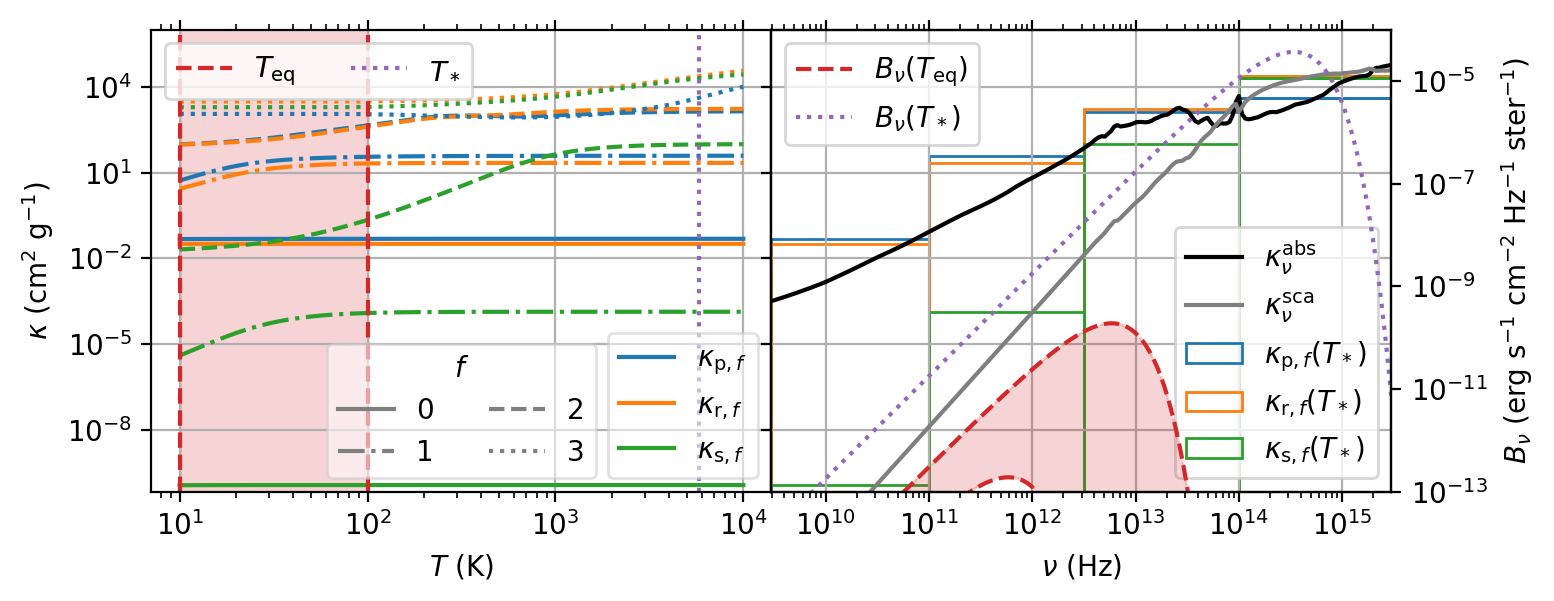

In [3]:
#===============================================================================
import athena_read
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Path
problem_id = 'dsharp'
root = '../athena/models/dsharp_abs-sca'
path = f'{root}/nfreq/4'

# BEGIN FROM athena_opac.py
#===============================================================================
# Make tables to compute mean opacities
athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
T_unit = athinput['radiation']['T_unit']                           # [K]
density_unit = athinput['radiation']['density_unit']               # [g/cm^3]
length_unit = athinput['radiation']['length_unit']                 # [cm]
ntemp = athinput['problem']['n_temperature']
temperature_min = athinput['problem']['temperature_min']           # [K]
temperature_max = athinput['problem']['temperature_max']           # [K]
temp_table = np.logspace(np.log10(temperature_min), np.log10(temperature_max),
                         ntemp)
Bnu_table = GetBnu_table(temp_table, opac_freq)
dBnu_dT_table = GetdBnu_dT_table(temp_table, opac_freq)

# For a single or multiple frequency bands
nu_min, nu_max = opac_freq[0], opac_freq[-1]
xlim = (nu_min, nu_max)
nfreq = athinput['radiation']['n_frequency']
kappa_pf_table = np.zeros((ntemp, nfreq))
kappa_rf_table = np.zeros((ntemp, nfreq))
if scattering:
    kappa_sf_table = np.zeros((ntemp, nfreq))
i_nu0 = 0                   # left frequency table index
i_nu1 = len(opac_freq) - 1  # right index
nu_grid = np.asarray([nu_min, nu_max])
if nfreq > 1:
    frequency_min = athinput['radiation']['frequency_min']         # [Hz]
    if frequency_min < 0:  # unit switch: code (<0) or cgs (>0)
        frequency_min *= -k*T_unit/h                               # [k_BT_0/h]
    nu_grid = np.asarray(frequency_min)   # frequency group f interfaces [Hz]
    
    if nfreq > 2:
        try:
            if (athinput['problem']['frequency_table'] == 1):
                fname = "freq_table.txt"
            nu_grid = np.loadtxt(f'{path}/{fname}')
            if len(nu_grid)+1 != nfreq:
                raise ValueError('`frequency_table` size does not match '\
                                 +'`nfreq`')
            if np.all(nu_grid < 0):  # unit switch: code (<0) or cgs (>0)
                nu_grid *= -k*T_unit/h                             # [k_BT_0/h]
        except KeyError:
            frequency_max = athinput['radiation']['frequency_max'] # [Hz]
            if frequency_max < 0:  # unit switch: code (<0) or cgs (>0)
                frequency_max *= -k*T_unit/h                       # [k_BT_0/h]
            nu_grid = np.logspace(np.log10(frequency_min),
                                  np.log10(frequency_max), nfreq-1)
    nu_grid = np.insert(nu_grid, 0, nu_min)
    nu_grid = np.append(nu_grid, nu_max)
    if nu_grid[0] < nu_min:
        warnings.warn('Lowest frequency group is below the lowest frequency '\
                      +'given by the opacity table')
    if nu_grid[-1] > nu_max:
        warnings.warn('Highest frequency group is above the highest frequency '\
                      +'given by the opacity table')
    i_nu1 = BinarySearchIncreasing(opac_freq, 0, len(opac_freq)-1, nu_grid[1])

for i in range(nfreq):
    kappa_pf_table[:, i] = PlanckMeanOpacities(opac_kabs[i_nu0:i_nu1],
                                               Bnu_table[:, i_nu0:i_nu1],
                                               opac_freq[i_nu0:i_nu1],
                                               temp_table)
    if scattering:
        kappa_rf_table[:, i] = RosselandMeanOpacities(opac_comb[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
        kappa_sf_table[:, i] = RosselandMeanOpacities(opac_ksca[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
    else:
        kappa_rf_table[:, i] = RosselandMeanOpacities(opac_kabs[i_nu0:i_nu1],
                                                      dBnu_dT_table[:, i_nu0:i_nu1],
                                                      opac_freq[i_nu0:i_nu1])
    i_nu0 = i_nu1
    if i < (nfreq - 2):  # intermediate frequency group
        i_nu1 = BinarySearchIncreasing(opac_freq, 0, len(opac_freq)-1,
                                       nu_grid[i+2])
    else:                      # (next-to-) last frequency group
        i_nu1 = len(opac_freq)-1
# END FROM athena_opac.py
#===============================================================================

# Plot
nu_peak = lambda temp: 5.879e10*temp # Wien's displacement law [Hz/K]
t_star = athinput['problem']['t_star']*T_unit  # [K]
t_eq_min = 10  # [K]
t_eq_max = 100 # [K]
i_temp = 920 # 920 = 5751 K
fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(8, 3), dpi=200)
c_handles, ls_handles, soln_handles = [], [], []
ax_bnu = axs[1].twinx()
lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5)),
       'solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
for i in range(nfreq):
    axs[0].plot(temp_table, kappa_pf_table[:, i], color='tab:blue', ls=lss[i])
    axs[0].plot(temp_table, kappa_rf_table[:, i], color='tab:orange', ls=lss[i])
    axs[0].plot(temp_table, kappa_sf_table[:, i], color='tab:green', ls=lss[i])
    ls_handles.append(axs[0].plot([], [], color='tab:gray', ls=lss[i],
                      label=f'{i}')[0])
axs[0].axvline(t_eq_max, color='tab:red', ls='dashed')
axs[0].fill_betweenx(np.logspace(-12, 8, 10), t_eq_min, t_eq_max,
                    color='tab:red', ls='dashed', alpha=0.2)
ax_bnu.plot(opac_freq, GetBnu_table([t_eq_min], opac_freq)[0], color='tab:red',
           ls='dashed', label=r'$B_\nu(T_\mathrm{eq})$')
ax_bnu.plot(opac_freq, GetBnu_table([t_eq_max], opac_freq)[0], color='tab:red',
           ls='dashed')
ax_bnu.fill_between(opac_freq, GetBnu_table([t_eq_min], opac_freq)[0],
                   GetBnu_table([t_eq_max], opac_freq)[0], color='tab:red',
                   ls='dashed', alpha=0.2,)
ax_bnu.plot(opac_freq, GetBnu_table([t_star], opac_freq)[0], color='tab:purple',
           ls='dotted', label=r'$B_\nu(T_*)$')
axs[1].bar(nu_grid[:-1], kappa_pf_table[i_temp, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:blue',
           label=rf'$\kappa_{{\mathrm{{p}},f}}(T_*)$')
axs[1].bar(nu_grid[-2], kappa_pf_table[i_temp, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:blue')
axs[1].bar(nu_grid[:-1], kappa_rf_table[i_temp, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:orange',
           label=rf'$\kappa_{{\mathrm{{r}},f}}(T_*)$')
axs[1].bar(nu_grid[-2], kappa_rf_table[i_temp, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:orange')
axs[1].bar(nu_grid[:-1], kappa_sf_table[i_temp, :], width=np.diff(nu_grid),
           align='edge', log=True, color='none', edgecolor='tab:green',
           label=rf'$\kappa_{{\mathrm{{s}},f}}(T_*)$')
axs[1].bar(nu_grid[-2], kappa_sf_table[i_temp, -1], width=1e16, align='edge',
           log=True, color='none', edgecolor='tab:green')
axs[1].plot(opac_freq, opac_kabs, 'black',
            label=r'$\kappa_\nu^\mathrm{abs}$')
axs[1].plot(opac_freq, opac_ksca, 'tab:gray',
            label=r'$\kappa_\nu^\mathrm{sca}$')
print(f'nu_peak(T_*) = {nu_peak(t_star):.2e} Hz')

# Multiple legends
soln_handles.append(axs[0].axvline(t_eq_min, color='tab:red', ls='dashed',
                    label=r'$T_\mathrm{eq}$'))
soln_handles.append(axs[0].axvline(t_star, color='tab:purple', ls='dotted',
                    label=r'$T_*$'))
c_handles.append(axs[0].plot([], [], color='tab:blue',
                 label=r'$\kappa_{\mathrm{p},f}$')[0])
c_handles.append(axs[0].plot([], [], color='tab:orange',
                 label=r'$\kappa_{\mathrm{r},f}$')[0])
c_handles.append(axs[0].plot([], [], color='tab:green',
                 label=r'$\kappa_{\mathrm{s},f}$')[0])
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=ls_handles,
                                loc='lower center', ncol=2, title=r'$f$'))
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=c_handles,
                                loc='lower right'))
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=soln_handles,
                                loc='upper left', ncol=2))

# Format plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True)
axs[0].set(xlabel=r'$T$ (K)',
           ylabel=r'$\kappa$ (cm$^2$ g$^{-1}$)')
axs[1].legend(loc='lower right')
axs[1].set(xlim=xlim, xlabel=r'$\nu$ (Hz)', ylim=(7e-11, 1e6))
ax_bnu.legend(loc='upper left')
ax_bnu.set(ylabel=r'$B_\nu$ (erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$ ster$^{-1}$)',
          yscale='log', ylim=(1e-13, 1e-4))
fig.subplots_adjust(wspace=0)
plt.savefig('figs/opacities.pdf', bbox_inches='tight', pad_inches=0.01)
#===============================================================================